In [ ]:
import pandas as pd
df = pd.read_csv('household_power_consumption.txt', sep=';', low_memory=False)
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [ ]:
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')
df = df.dropna(subset=['Global_active_power'])

In [ ]:
def label_load(power):
    if power == 0:
        return 'off'
    elif power < 0.1:
        return 'phantom'
    else:
        return 'active'

df['Load_State'] = df['Global_active_power'].apply(label_load)

In [ ]:
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H:%M:%S')
df['Hour'] = df['Datetime'].dt.hour
df['DayOfWeek'] = df['Datetime'].dt.dayofweek

In [ ]:
features = df[['Global_active_power', 'Hour', 'DayOfWeek']]
labels = df['Load_State']

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(features, labels_encoded, test_size=0.2, random_state=42)


clf = RandomForestClassifier()
clf.fit(X_train, y_train)


y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

      active       1.00      1.00      1.00    407528
     phantom       1.00      1.00      1.00      2328

    accuracy                           1.00    409856
   macro avg       1.00      1.00      1.00    409856
weighted avg       1.00      1.00      1.00    409856



In [ ]:
import joblib
joblib.dump(clf, 'phantom_load_detector.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')

['label_encoder.pkl']

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:

y_pred_labels = label_encoder.inverse_transform(y_pred)
y_test_labels = label_encoder.inverse_transform(y_test)

output_df = X_test.copy()
output_df['Actual'] = y_test_labels
output_df['Predicted'] = y_pred_labels

print(output_df.head(10))

         Global_active_power  Hour  DayOfWeek  Actual Predicted
1030580                1.502     9          0  active    active
1815                   0.374    23          6  active    active
1295977                0.620    17          2  active    active
206669                 0.280     5          2  active    active
1048893                1.372     2          6  active    active
270672                 0.284    16          4  active    active
1395384                0.196    17          1  active    active
735922                 2.234    18          5  active    active
1566601                0.486    15          1  active    active
1605907                1.842    22          0  active    active


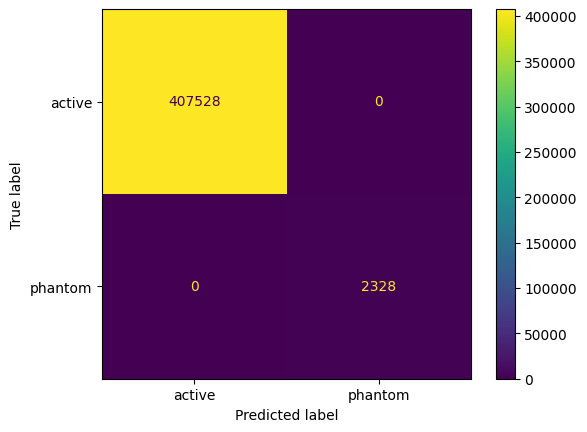

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot()

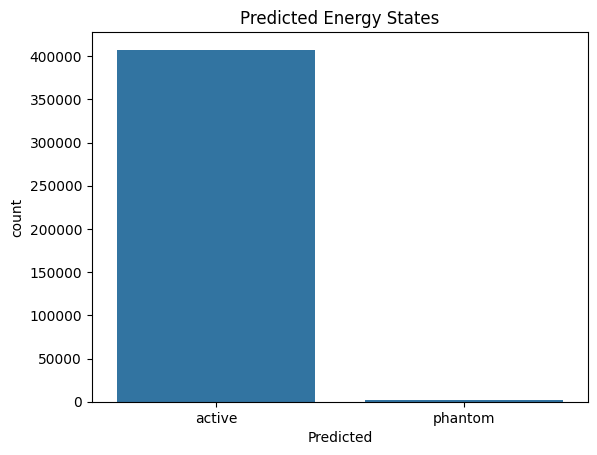

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=output_df['Predicted'])
plt.title("Predicted Energy States")
plt.show()

In [ ]:
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')
df = df.dropna()

In [ ]:
df['Power_kW'] = pd.to_numeric(df['Global_active_power'], errors='coerce')
df = df.dropna()

def label_load(power):
    if power == 0:
        return 'off'
    elif power < 0.1:
        return 'phantom'
    else:
        return 'active'

df['Load_State'] = df['Power_kW'].apply(label_load)


/tmp/ipython-input-7-747364736.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Power_kW'] = pd.to_numeric(df['Global_active_power'], errors='coerce')


In [ ]:
X = df[['Power_kW']]
y = df['Load_State']

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
from sklearn.metrics import classification_report
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      active       1.00      1.00      1.00    129535
     phantom       1.00      1.00      1.00       127

    accuracy                           1.00    129662
   macro avg       1.00      1.00      1.00    129662
weighted avg       1.00      1.00      1.00    129662



In [ ]:
import joblib
joblib.dump(clf, 'phantom_load_model.pkl')

['phantom_load_model.pkl']

In [ ]:
features = df[['Global_active_power', 'Hour', 'DayOfWeek']]

In [ ]:
from sklearn.ensemble import IsolationForest

anomaly_model = IsolationForest(contamination=0.01, random_state=42)
anomaly_model.fit(features)

IsolationForest(contamination=0.01, random_state=42)

In [ ]:
df['Anomaly'] = anomaly_model.predict(features)

In [ ]:
anomalies = df[df['Anomaly'] == -1]
print(anomalies[['Global_active_power', 'Hour', 'DayOfWeek']].head())

    Global_active_power  Hour  DayOfWeek
20                5.894    17          5
21                7.706    17          5
22                7.026    17          5
41                6.052    18          5
42                6.752    18          5


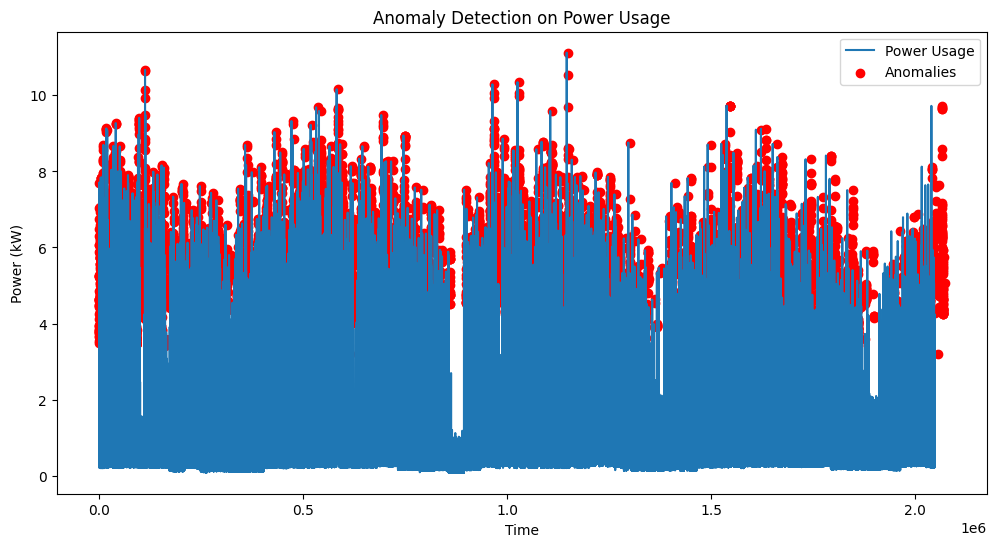

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(df['Global_active_power'].values, label='Power Usage')
plt.scatter(anomalies.index, anomalies['Global_active_power'], color='red', label='Anomalies')
plt.legend()
plt.title("Anomaly Detection on Power Usage")
plt.xlabel("Time")
plt.ylabel("Power (kW)")
plt.show()